# GHZ states and non-local measurements 
This notebook demonstrates a PyQuil implementation of a version of the [Greenberger–Horne–Zeilinger](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state) (GHZ) experiment that was [popularized by David Mermin](http://www.phy.pku.edu.cn/~qiongyihe/content/download/3-2.pdf).  

In [1]:
import itertools
import time
import math
from typing import List
from collections import Counter

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = 'none'

from pyquil import get_qc, Program
from pyquil.gates import CNOT, H, MEASURE, RESET, RX, RY
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from hello_qmi import get_active_lattice

n_shots = 10_000

## Creating PyQuil programs
First, we create a function to generate Quil programs for us.  It sets the first qubit to the superposition state $\left| \uparrow \right>$ using the [Hadamard](https://en.wikipedia.org/wiki/Quantum_logic_gate#Hadamard_(H)_gate) gate and then generates a GHZ state (which looks like $\left| \uparrow \uparrow \uparrow \right> + \left| \downarrow \downarrow \downarrow \right>$  for 3 qubits) by applying [Controlled-NOT](https://en.wikipedia.org/wiki/Controlled_NOT_gate) (`CNOT`) gates between the first qubit and the others.  It then measures each of the qubits in turn along either the X, Y or Z axes.  (In Quil we can only measure along the Z axis, but we measure along the others by rotating the qubit first).  

In [2]:
"""
This function places three qubits in a GHZ state and then measures them along some combination of
the X, Y or Z axes, as specified by `measure`.  
"""
def ghz_program(qubits: List[int], measure: List[str], include_measure = True) -> Program:
    assert len(qubits) == len(measure)
    assert all(m in 'XYZ' for m in measure)
    program = Program(RESET())
    program.inst(H(qubits[0]))
    for i in range(len(qubits) - 1):
        program.inst(CNOT(qubits[i], qubits[i + 1]))
    for i in range(len(measure)):
        if measure[i] == 'X':
            program.inst(RY(-math.pi/2, qubits[i]))
        elif measure[i] == 'Y':
            program.inst(RX(math.pi/2, qubits[i]))
        else: #  measure[i] == 'Z'
            # We don't need to do anything since we measure along the Z axis by default
            pass
    if include_measure:
        ro = program.declare('ro', 'BIT', len(qubits))
        program.inst([MEASURE(qubit, ro[idx]) for idx, qubit in enumerate(qubits)])
    return program

This program looks a bit complicated, but we can inspect the actual sequence of gates that it will run for a given set of measurements.

In [3]:
p = ghz_program(range(3), ['X', 'Y', 'Y'])
print(p)

RESET
H 0
CNOT 0 1
CNOT 1 2
RY(-pi/2) 0
RX(pi/2) 1
RX(pi/2) 2
DECLARE ro BIT[3]
MEASURE 0 ro[0]
MEASURE 1 ro[1]
MEASURE 2 ro[2]



If you're more familiar with circuit diagrams, our sample program looks like this:

<img src="figures/Raw circuit.png" width="500">

The program above only makes a single measurement at a time, so we make another function to run it a large number of times and summarize the results.

In [4]:
# A function for actually running measurements and storing the responses
def do_measurements(qubits, measurement_set):
    raw_results = {}
    for measurement in measurement_set:
        program = ghz_program(qubits, measurement, False)
        # Try to do http://docs.rigetti.com/en/stable/apidocs/autogen/pyquil.api.QuantumComputer.run_symmetrized_readout.html?highlight=readout%20bias
        raw_results[tuple(measurement)] = qpu.run_symmetrized_readout(program, n_shots)
#         program.wrap_in_numshots_loop(n_shots)
#         cp = qpu.compile(program)    
#         raw_results[tuple(measurement)] = qpu.run(cp)
        hist = {mx: Counter(tuple(2*i-1) for i in raw_results[mx]) for mx in raw_results}
        probs = {mx: {m: hist[mx][m]/n_shots for m in hist[mx]} for mx in hist}
    return probs

We can also make a function to plot our results as a histogram of the measured outcomes.

In [5]:
def plot_results(results):
    outcomes = [-1, +1]
    possible_results = [(i, j, k) for i in outcomes for j in outcomes for k in outcomes]
    fig = make_subplots(rows=1, cols=3, 
                        subplot_titles = ['(' + ", ".join(mx) + ')' for mx in results])
    for i, mx in enumerate(results):
        fig.append_trace(
            go.Bar(x = ['(' + ' '.join('↑' if i == 1 else '↓' for i in r) + ')' for r in possible_results], 
                   y = [results[mx].get(r, 0) for r in possible_results],
                  showlegend=False),
            row=1, col=i+1
        )
        fig.update_yaxes(title='Probability', tickformat=".0%", row=1, col=i+1)
        fig.update_xaxes(tickangle=45, tickfont=dict(size=14))
    fig.show()

## Making measurements

Next, we start up a Quantum Virtual Machine to run this simulation on and select three qubits to use.  

In [12]:
# These first two lines can be used to connect to an actual device instead of the QVM
#lattice = get_active_lattice()
#qpu = get_qc(lattice)
qpu = get_qc('9q-generic-qvm')
qubits = qpu.device.qubits()[1:4]

Our sample program above contains some gates which can't be performed on our QPU directly.  Fortunately, the compiler knows how to rewrite our program using  the set of allowable gates.  In this example, you can see that a `RY(-pi/2) 0` gate has been replaced with an equivilent sequence of gates, `RX(pi/2) 0` and `RZ(-pi/2) 0`.  

In [13]:
p = ghz_program(qubits, ['X', 'Y', 'Y'])
np = qpu.compiler.quil_to_native_quil(p)
print(np)

DECLARE ro BIT[3]
RESET
RZ(1.5707963267948968) 1
RX(pi/2) 1
RZ(-pi/2) 2
RX(pi/2) 2
CZ 2 1
RX(-pi/2) 2
RZ(-pi/2) 3
RX(pi/2) 3
CZ 3 2
RX(pi/2) 1
RZ(-pi/2) 1
RZ(-pi/2) 2
RX(pi/2) 2
RZ(pi/2) 3
RX(pi/2) 3
RZ(-pi/2) 3
MEASURE 3 ro[2]
MEASURE 2 ro[1]
MEASURE 1 ro[0]



/home/forest/.virtualenvs/venv/lib/python3.6/site-packages/rpcq/_client.py:177: UserWarning:

SIMPLE-WARNING: Chip specification contained fidelity 1.0d0 > 1. Truncating to 0.99999d0.



### Measuring (Z, Z, Z)
What happens when we measure all three qubits along the Z axis?  Our state is a superposition of the $\left| \uparrow \uparrow \uparrow \right>$ and $ \left| \downarrow \downarrow \downarrow \right>$ states so we expect to get one of those two results.

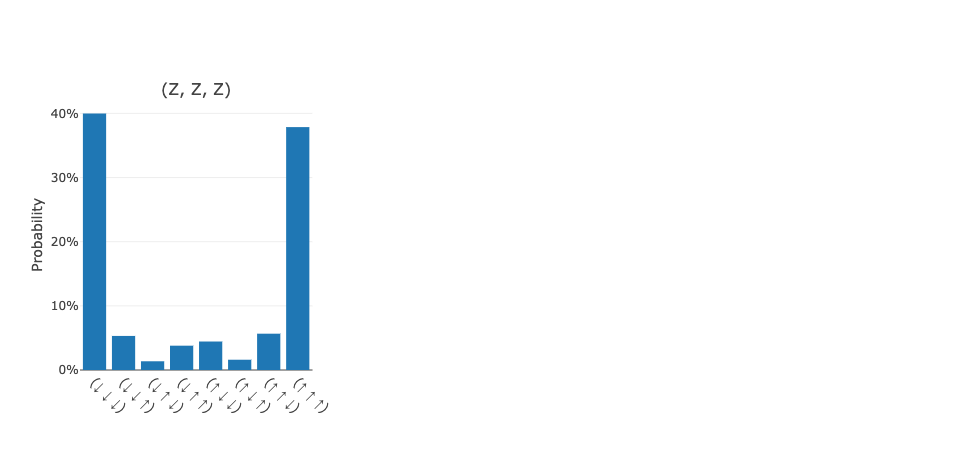

In [14]:
three_z_results = do_measurements(qubits, [['Z', 'Z', 'Z']])
plot_results(three_z_results)

<img src="figures/ZZZ.png" width="500"> <br />
<em>(Here's the result rendered to a static image for offline viewing).  </em>

### Measuring (X, X, X)
What happens if we measure all three qubits along the X axis?  

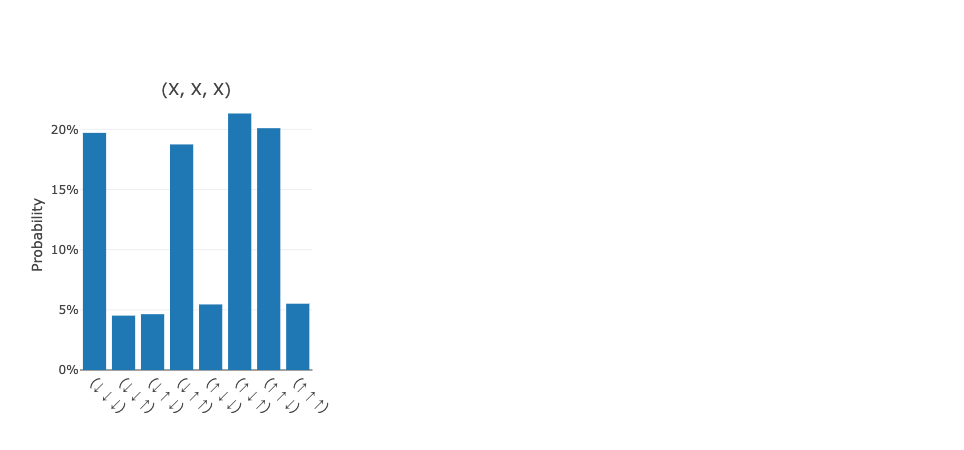

In [15]:
three_x_results = do_measurements(qubits, [['X', 'X', 'X']])
plot_results(three_x_results)

<img src="figures/XXX.png" width="500"> <br />
<em>(Here's the result rendered to a static image for offline viewing).  </em>

We get one of four possible results.  Either all of the qubits are in the $\downarrow$ state or exactly one of them is.  If we think about the down state corresponding to -1 and the up state to +1 then this means that the only results we see are where

$$
X_1 X_2 X_3 = -1
$$

is true.

### Measuring one X and two Y

What about measuring one qubit along the X axis and the other along Y?  We can try all possible combinations:

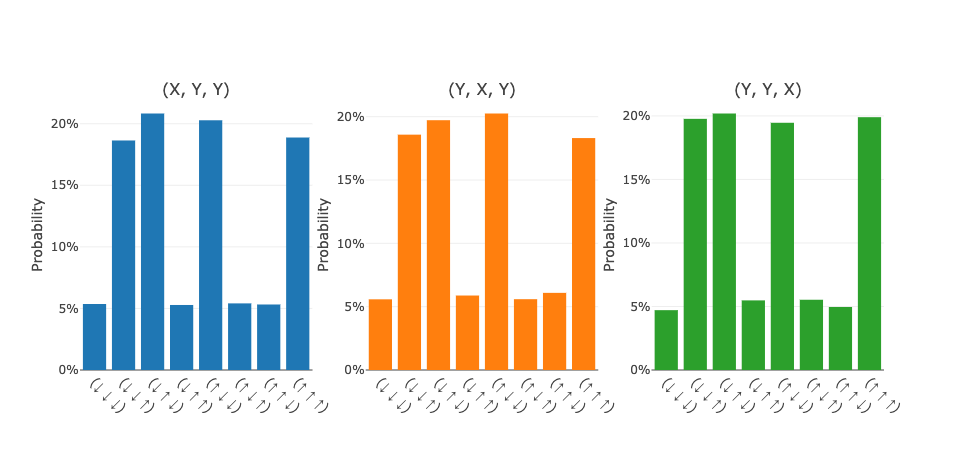

In [16]:
two_x_one_y = [
    ['X' if j == i else 'Y' for j in range(len(qubits))]
    for i in range(len(qubits))
]
two_x_one_y_results = do_measurements(qubits, two_x_one_y)
plot_results(two_x_one_y_results)

<img src="figures/XYY.png" width="500"> <br />
<em>(Here's the result rendered to a static image for offline viewing).  </em>

In each case, if the qubit we measured along the X axis is down then the two qubits we measured along the Y axis have different results.  If the X qubit is up then the two other qubits have the same result.  From this, we can write out three more equalities: 

$$
X_1 Y_2 Y_3 = 1 \\
Y_1 X_2 Y_3 = 1 \\
Y_1 Y_2 X_3 = 1
$$


## Ruling out deterministic local states

Can these results be explained by assigning each qubit a value for its measurement along the X and Y axis prior to the measurements taking place?  We can quickly check this by multiplying the four equations above together to get:

$$
(X_1)^2 (X_2)^2 (X_3)^2 (Y_1)^2 (Y_2)^2 (Y_3)^2 = -1
$$

This is a contradiction since each measurement value is ±1, and this demonstrates that the set of qubits could not have predetermined local states.  

